In [10]:
%matplotlib inline

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
new_data = json.load(open("./data/cloth_body_face_meta.json"))
test_data = json.load(open("./result/test_cloth_body_meta.json"))
test_ids = json.load(open("./data/test_ids.json"))
clean_train_ids = json.load(open("./data/train_ids_0.0.json"))

In [12]:
print("dataset length: ", len(new_data))
print("clean training data length", len(clean_train_ids))
print("test data length", len(test_ids))
print("all labelled data is: ", len(clean_train_ids)+len(test_ids))

dataset length:  80629
clean training data length 22367
test data length 8062
all labelled data is:  30429


In [13]:
def three_order_attr(cat, attr_set):
    cloth_set = set()
    for i in attr_set:
        cloth_set.add(":::".join([cat, i]))
    
    """
    if len(attr_set) < 2:
        return cloth_set
    for i in attr_set:
        for j in attr_set:
            if i != j:
                cloth_set.add(":::".join([cat] + sorted([i, j])))
     
    if len(attr_set) < 3:
        return cloth_set
    for i in attr_set:
        for j in attr_set:
            if i != j:
                for k in attr_set:
                    if k != i and k != j:
                        cloth_set.add(":::".join([cat] + sorted([i, j, k])))   
    """
    return cloth_set


def get_clothes_cnt_by_body(clean_train_ids, new_data):
    occ_clothes_cnt = {}
    one_cloth = 0
    multi_cloth = 0
    for id_ in clean_train_ids:
        res = new_data[id_]["cloth_body_face"]
        occ = new_data[id_]["occasion"]
        if occ not in occ_clothes_cnt:
            occ_clothes_cnt[occ] = {}
            
        body_attr_set = {}  
        for each in res: 
            body_str = "_".join([str(int(x)) for x in each["body"]])
            gender = each["gender"]
            body_str = ",".join([body_str, gender])
            
            cloth = each["cloth"]
            big_cat, cat = cloth["category"].split("__")
            attr_set = set()
            for k, v in cloth.items():
                if k not in ["category", "box"]:
                    attr_set.add(k)

            tmp_set = three_order_attr(cat, attr_set)
                                 
            if body_str in body_attr_set:
                body_attr_set[body_str].append(tmp_set)
            else:
                body_attr_set[body_str] = [tmp_set]
                    
        for body_str, tmpset_list in body_attr_set.items():
            gender = body_str.split(",")[1]
            if gender not in occ_clothes_cnt[occ]:
                occ_clothes_cnt[occ][gender] = {}
                
            for tmp_set in tmpset_list:
                for i, attr in enumerate(sorted(tmp_set)):
                    if attr not in occ_clothes_cnt[occ][gender]:
                        occ_clothes_cnt[occ][gender][attr] = 1
                    else:
                        occ_clothes_cnt[occ][gender][attr] += 1

            
            if len(tmpset_list) == 1:
                one_cloth += 1
            else:
                multi_cloth += 1
                """
                for i, tmp_set in enumerate(tmpset_list):
                    for tmp_set_1 in tmpset_list[i:]:
                        for attr1 in tmp_set:
                            for attr2 in tmp_set_1:
                                concat_attr = ",".join([attr1, attr2])
                                if concat_attr not in occ_clothes_cnt[occ][gender]:
                                    occ_clothes_cnt[occ][gender][concat_attr] = 1
                                else:
                                    occ_clothes_cnt[occ][gender][concat_attr] += 1
                """
                                    
    print("one cloth cnt: %d, multi cloth cnt: %d" %(one_cloth, multi_cloth))
                    
    return occ_clothes_cnt
                    
occ_cloth_cnt = get_clothes_cnt_by_body(clean_train_ids, new_data)

one cloth cnt: 19036, multi cloth cnt: 7914


In [14]:
def get_pop_cat_attr(occ_cloth_cnt):
    occ_catattr_cnt = {}
    catattr_cnt = {}
    for occ, reses in occ_cloth_cnt.items():
        if occ not in occ_catattr_cnt:
            occ_catattr_cnt[occ] = {}
        for gender, res in reses.items():
            for attr, cnt in res.items():
                if attr not in occ_catattr_cnt[occ]:
                    occ_catattr_cnt[occ][attr] = cnt
                else:
                    occ_catattr_cnt[occ][attr] += cnt
                if attr not in catattr_cnt:
                    catattr_cnt[attr] = cnt
                else:
                    catattr_cnt[attr] += cnt
                
    return occ_catattr_cnt, catattr_cnt

occ_catattr_cnt, catattr_cnt = get_pop_cat_attr(occ_cloth_cnt)

In [8]:
def get_topk_knowledge(occ_catattr_cnt, thresh=20):
    k_set = set()
    for occ, res in occ_catattr_cnt.items():
        cnt = 0
        for k, v in sorted(res.items(), key=lambda i: i[1], reverse=True):
            if cnt > 20:
                #print("")
                break
            #print(k, v)
            k_set.add(k)
            cnt += 1
            
    return k_set

k_set = get_topk_knowledge(occ_catattr_cnt)
print(len(k_set))

72


(20, 64)


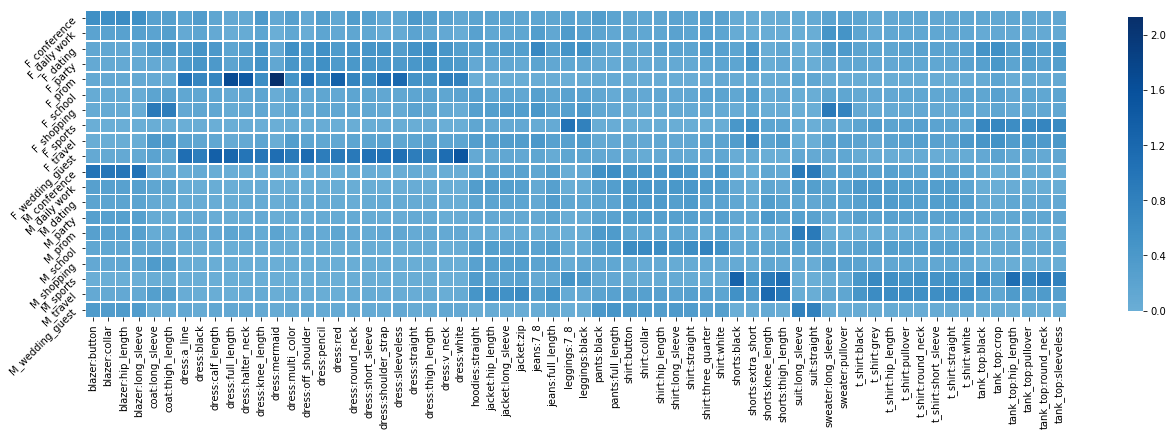

(20, 64)


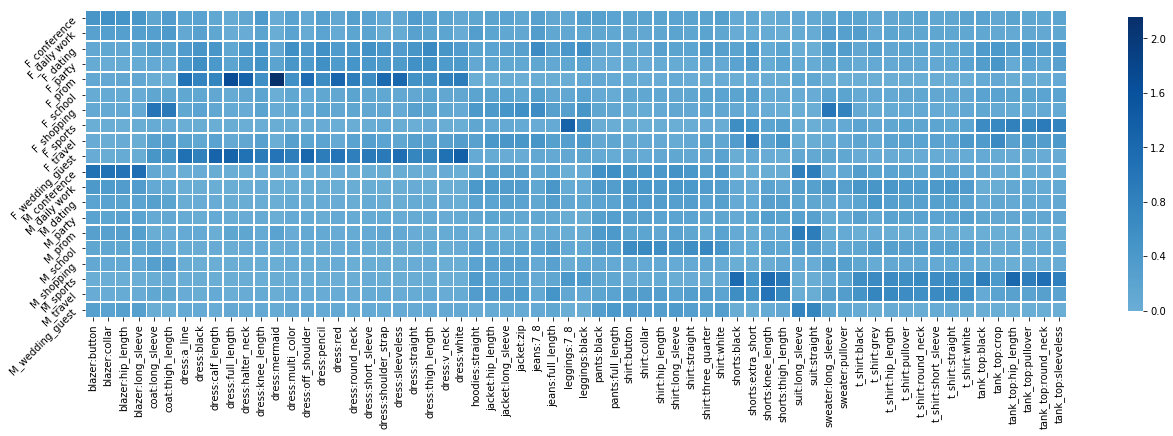

In [15]:
def plot_corr(corr, xticker, yticker, name):
    #sns.set(style="white")
    plt.rcParams.update({'font.size': 10})
    fig1, ax1 = plt.subplots(figsize=(22, 18))
    cmap = sns.diverging_palette(359, 0, s=80, center="light", as_cmap=True)
    #sns.heatmap(corr, cmap="PiYG", center=0, xticklabels=xticker, yticklabels=yticker,
    #            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr, cmap="Blues", center=0, xticklabels=xticker, yticklabels=yticker,
                square=True, linewidths=.5, cbar_kws={"shrink": .3})
    plt.xticks(rotation=90)
    plt.yticks(rotation=45)
    #plt.title("statistics of %s" %(name))
    plt.show()
    fig1.savefig("%s.pdf" %(name), bbox_inches='tight')


def plt_each_corr(key_val_cnt, name):
    key_set = set()
    val_set = set()
    for key, res in key_val_cnt.items():
        key_set.add(key)
        for val, cnt in res.items():
            val_set.add(val)
            
    key_code = {}
    key_list = []
    for i, key in enumerate(sorted(list(key_set))):
        key_code[key] = i
        key_list.append(key)
        
    val_code = {}
    val_list = []
    for i, val in enumerate(sorted(list(val_set))):
        val_code[val] = i
        val_list.append(val)
    
    key_val_np = np.zeros((len(key_set), len(val_set)))
    for key, res in key_val_cnt.items():
        key = key_code[key]
        for val, cnt in res.items():
            val = val_code[val]
            key_val_np[key][val] = cnt
            
    #key_val_np = (key_val_np - np.mean(key_val_np)) / (np.max(key_val_np) - np.mean(key_val_np))# * 100
    print(key_val_np.shape) # [20, 42]
    for i in range(key_val_np.shape[1]):
        ratio_0 = np.sum(key_val_np[:10, i]) / (np.sum(key_val_np[:10, i]) + np.sum(key_val_np[10:, i]))
        ratio_1 = np.sum(key_val_np[10:, i]) / (np.sum(key_val_np[:10, i]) + np.sum(key_val_np[10:, i]))
        
        if np.sum(key_val_np[:10, i]) == 0:
            key_val_np[:10, i] = 0.01
        else:
            key_val_np[:10, i] = key_val_np[:10, i] / np.sum(key_val_np[:10, i]) * ratio_0
        if np.sum(key_val_np[10:, i]) == 0:
            key_val_np[10:, i] = 0.01
        else:
            key_val_np[10:, i] = key_val_np[10:, i] / np.sum(key_val_np[10:, i]) * ratio_1
    key_val_np = key_val_np * 4
            
    #key_val_np = key_val_np / np.max(key_val_np)
    #key_val_np = np.log(key_val_np*100)
    
    if len(key_list) > len(val_list):
        x_ticker = key_list
        y_ticker = val_list
        print(key_val_np.shape)
        key_val_np = key_val_np.transpose((1, 0))
        print(key_val_np.shape)
        print("")
    else:
        x_ticker = val_list
        y_ticker = key_list
    
    plot_corr(key_val_np, x_ticker, y_ticker, name)

    
def plot_occ_popcloth(clean_train_ids, new_data, catattr_set):
    occ_clothes_cnt = {}
    compulse_convert_ids = set()
    for id_ in clean_train_ids:
        if id_ not in new_data:
            print("not found: ", id_)
            continue
        res = new_data[id_]["cloth_body_face"]
        ori_occ = new_data[id_]["occasion"]
        
        for each in res: 
            gender = each["gender"]
            cloth = each["cloth"]
            big_cat, cat = cloth["category"].split("__")
            if "dress" in cat or "skirt" in cat or "leggings" in cat:
                if gender == "M":
                    compulse_convert_ids.add(id_)
                #gender = "F"
            occ = gender + "_" + ori_occ
            if occ not in occ_clothes_cnt:
                occ_clothes_cnt[occ] = {}
            attr_set = set()
            for k, v in cloth.items():
                if k not in ["category", "box"]:
                    catattr = ":::".join([cat, k])
                    if catattr in catattr_set:
                        if catattr not in occ_clothes_cnt[occ]:
                            occ_clothes_cnt[occ][catattr] = 1
                        else:
                            occ_clothes_cnt[occ][catattr] += 1
    
    occ_mapping = {
        "F_work": "F_daily work",
        "M_work": "M_daily work",
        "F_date": "F_dating",
        "M_date": "M_dating",
        "F_sport": "F_sports",
        "M_sport": "M_sports"
    }
    
    new = {}
    for occ, attr_cnt in occ_clothes_cnt.items():
        if occ in occ_mapping:
            occ = occ_mapping[occ]
        if occ not in new:
            new[occ] = {}
        for attr, cnt in attr_cnt.items():
            cat, attr = attr.split(":::")
            attr, val = attr.split(":")
            if val == "na":
                continue
            if attr in ["pants_fit_type", "denim_wash_color"]:
                continue
            if val == "other":
                continue
            if val == "long":
                val = "long_sleeve"
            if val == "short":
                val = "short_sleeve"
            if val == "multi":
                val = "multi_color"
            if cat == "sweatshirt_hoodies":
                cat = "hoodies"
            x = "%s:%s" %(cat, val)
            
            new[occ][x] = cnt
                            
    plt_each_corr(new, "occ_popcloth")
    json.dump(list(compulse_convert_ids), open("z_error_gender_ids.json", "w"))
    
    return new
    
train_mat = plot_occ_popcloth(clean_train_ids, new_data, k_set)
test_mat = plot_occ_popcloth(test_ids, new_data, k_set)

not found:  bfd3a531e553e8c5209b0a4f94c6c66d
not found:  9c63ebb6edb26348ccbe6f9c421fa863
(20, 64)


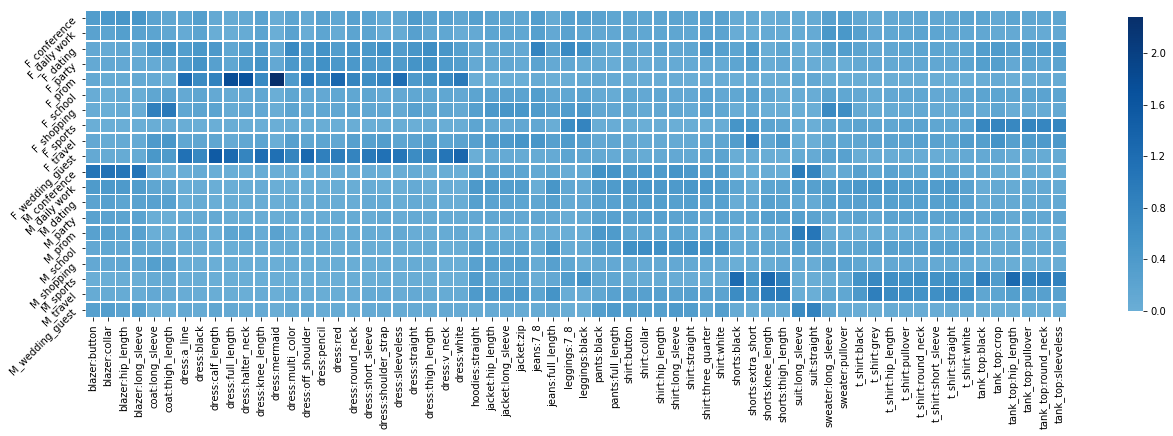

In [16]:
test_pred_mat = plot_occ_popcloth(test_ids, test_data, k_set)

In [30]:
print(test_mat["M_prom"]["dress:mermaid"])
print(test_mat["F_prom"]["dress:mermaid"])
print(test_mat["M_prom"]["dress:knee_length"])

10
97
7


In [37]:
for k, v in test_mat.items():
    if "F_" in k:
        print(k, v["blazer:hip_length"])

F_conference 44
F_daily work 27
F_dating 10
F_prom 11
F_shopping 9
F_party 6
F_travel 4
F_wedding_guest 6
F_sports 1
F_school 6


In [38]:
for k, v in test_mat.items():
    if "M_" in k:
        print(k, v["blazer:hip_length"])

M_shopping 9
M_school 14
M_party 21
M_wedding_guest 25
M_prom 24
M_conference 95
M_daily work 32
M_sports 1
M_dating 17
M_travel 5
